In [1]:
import pandas as pd
import numpy as np

In [66]:
# Loading mapping files
mapping_to_token = pd.read_csv("../csv_files/bookstore_csv/mapping_token.csv")
mapping_to_ast = pd.read_csv("../csv_files/bookstore_csv/mapping_ast.csv")
mapping_to_comp_ast = pd.read_csv("../csv_files/bookstore_csv/mapping_comp_ast.csv")
mapping_to_rel_ast = pd.read_csv("../csv_files/bookstore_csv/mapping_relative_ast.csv")

mapping = {"token" : mapping_to_token, "ast" : mapping_to_ast, "comp_ast" : mapping_to_comp_ast, "relative_ast" : mapping_to_rel_ast}

d_type = {"commit_hash" : "str", 	"num_additions" : int,	"num_deletions": int, "filename" : "str"}

# Function for loading data
def load_data(file):
    df = pd.read_csv(file)
    df = df[df.filename.str.endswith(".java")]
    return pd.DataFrame({"commit_hash": df.commit_hash, "changes": pd.to_numeric(df.num_additions) + pd.to_numeric(df.num_deletions)})

# Loading data
data_java = load_data("../csv_files/bookstore_csv/output_java.csv")
data_java_nws = load_data("../csv_files/bookstore_csv/output_nws.csv") 
data_token = load_data("../csv_files/bookstore_csv/output_token.csv")
data_ast = load_data("../csv_files/bookstore_csv/output_ast.csv")
data_comp_ast = load_data("../csv_files/bookstore_csv/output_comp_ast.csv")
data_rel_ast = load_data("../csv_files/bookstore_csv/output_relative_ast.csv")

data = {"java" : data_java, "java_nws" : data_java_nws, "token" : data_token, "ast" : data_ast, "comp_ast" : data_comp_ast, "relative_ast" : data_rel_ast}

In [65]:
# Setting up dataframes
df_java = data_java.groupby('commit_hash').sum()
df_java_nws = data_java_nws.groupby('commit_hash').sum()
df_token = pd.merge(data_token, mapping_to_token, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_token"}).drop(columns=["to", "commit_hash_token"]).groupby('commit_hash').sum()
df_ast = pd.merge(data_ast, mapping_to_ast, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_ast"}).drop(columns=["to", "commit_hash_ast"]).groupby('commit_hash').sum()
df_comp_ast = pd.merge(data_comp_ast, mapping_to_comp_ast, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_comp_ast"}).drop(columns=["to", "commit_hash_comp_ast"]).groupby('commit_hash').sum()
df_rel_ast = pd.merge(data_rel_ast, mapping_to_rel_ast, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_rel_ast"}).drop(columns=["to", "commit_hash_rel_ast"]).groupby('commit_hash').sum()

dfs = {"java" : df_java, "java_nws" : df_java_nws, "token" : df_token, "ast" : df_ast, "comp_ast" : df_comp_ast, "relative_ast" : df_rel_ast}

In [67]:
def mergeall(**dfs):
    items = dfs.items()
    table = df_java.rename(columns = dict(changes="repo"))
    for key, df in items:
        table = pd.merge(table, df.rename(columns = dict(changes=key)), left_index=True, right_index=True, validate="1:1", how="outer")
    return table

df_merged = mergeall(nws = df_java_nws, token = df_token, ast = df_ast, compressed_ast = df_comp_ast, relative_ast = df_rel_ast).fillna(0, downcast="int64")

df_merged.isna().sum()

repo              0
nws               0
token             0
ast               0
compressed_ast    0
relative_ast      0
dtype: int64

<Axes: >

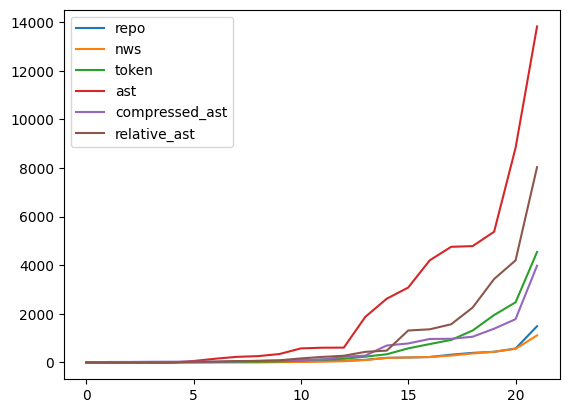

In [68]:
df = pd.DataFrame({k : np.array(df_merged[k].sort_values()) for k in df_merged.columns})
df.plot()

<Axes: >

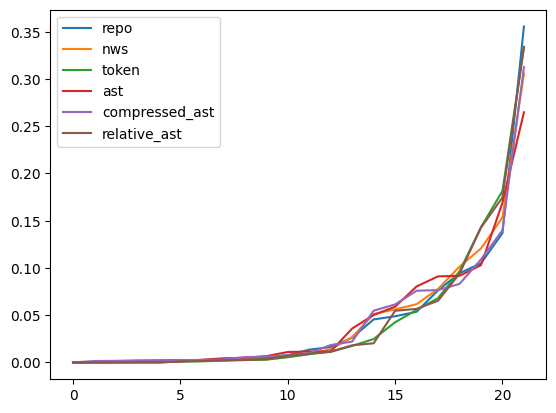

In [69]:
(df / df.sum()).plot()

<Axes: >

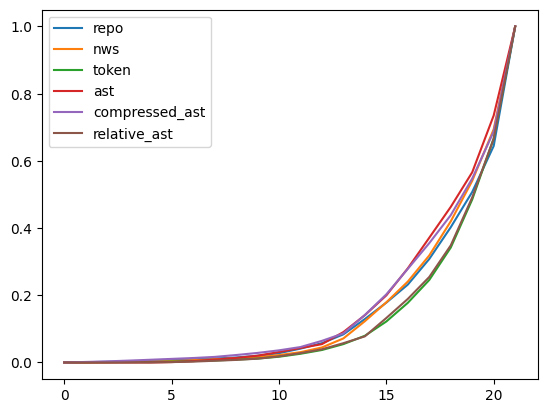

In [70]:
(df.cumsum() / df.sum()).plot()

<Axes: >

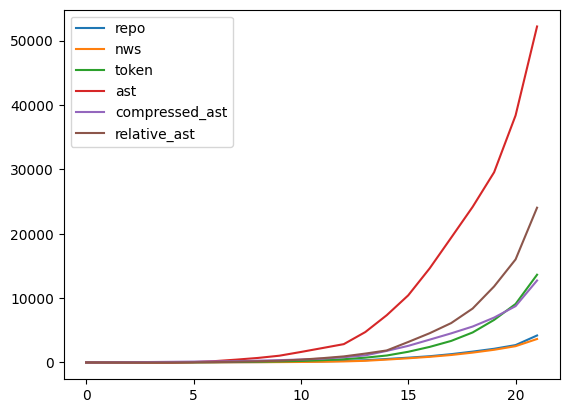

In [71]:
df.cumsum().plot()

In [24]:
#find størrelsen af filen for at finde en relativ ændring 
df_merged[df_merged.repo != 0][df_merged.nws == 0]

,repo,nws,token,ast,compressed_ast,relative_ast
commit_hash,,,,,,
cae53570875b772b7377f0645063fd1b99586994,68,0,0,0,0,0


In [ ]:
# from collections import deque
# from tree_sitter import Language, Parser
# import os
# from formast.__main__ import JAVA_LANGUAGE

# parser = Parser()
# parser.set_language(JAVA_LANGUAGE)

# with open("..\java_files\simple.java", "rb") as f:
#     code = f.read()
# tree = parser.parse(code)

# tree

In [ ]:
# import base64
# import hashlib

# def process_tree_comp(tree):
#     lookup = {}
#     lines = []

#     def process_node(node):
#         line = ""

#         if node.children:
#             children = []
#             for child in node.children:
#                 child_result = process_node(child)
#                 if child_result is not None:
#                     children.append(child_result)
#             line = 'B {} {}'.format(node.type, ' '.join(map(str, children)))
#         else:
#             text = node.text.decode('utf-8')
#             line = 'L {}'.format(text)

#         idx = lookup.get(line)
#         if idx is not None:
#             return idx

#         hash_object = hashlib.sha256(line.encode('utf-8'))
#         hash_value = int.from_bytes(hash_object.digest()[:8], byteorder='big', signed=True)
#         idx = base64.urlsafe_b64encode(hash_value.to_bytes(8, byteorder='big', signed=True)).rstrip(b'=').decode('ascii')
#         lines.append('{} {}'.format(idx, line))
#         lookup[line] = idx

#         return idx

#     process_node(tree.root_node)
#     return '\n'.join(lines).replace('{', '').replace('}', '')  

# print(process_tree_comp(tree))

In [ ]:
# def process_tree_relatively(tree):
#     output = []
#     stack = deque([(tree.root_node, -1)])
#     while stack:
#         node, parent_index = stack.pop()
#         if node.type == 'program':
#             output.append(f'N {node.type}')
#             parent_index = len(output) - 1
#         elif node.type in ['modifiers', 'identifier', 'class_body']:
#             output.append(f'N {node.text.decode("utf-8")}')
#             output.append(f'B {node.type} -1')
#             parent_index = len(output) - 1
#         elif node.type == 'class_declaration':
#             child_indices = []
#             for i, child in enumerate(node.children):
#                 if child.type in ['modifiers', 'identifier', 'class_body']:
#                     child_indices.append(i - len(node.children))
#             output.append(f'B {node.type} {" ".join(map(str, child_indices))}')
#             parent_index = len(output) - 1
#         for child in reversed(node.children):
#             stack.append((child, parent_index))
#     return '\n'.join(output)


# print(process_tree_relatively(tree))

In [ ]:
# from tree_sitter import Node

# def print_node(node: Node, indent: str = ""):
#     print(f"{indent}{node.type} [{node.start_point[0]}, {node.start_point[1]}] - [{node.end_point[0]}, {node.end_point[1]}]")
#     for child in node.children:
#         print_node(child, indent + "  ")

# print_node(tree.root_node)

In [ ]:
# def process_tree(tree, code):
#     lines = []
#     def process_node(node):
#         if node.type == 'identifier':
#             lines.append(f'N {code[node.start_byte:node.end_byte].decode("utf-8")}')
#             lines.append(f'B identifier -1')
#             return len(lines) - 1
#         elif node.type == 'class':
#             return None
#         elif node.type == 'class_body':
#             children = []
#             for child in node.children:
#                 if child.type not in ['{', '}']:
#                     child_index = process_node(child)
#                     if child_index is not None:
#                         children.append(child_index)
#             lines.append(f'B {node.type}')
#             return len(lines) - 1
#         else:
#             children = []
#             for child in node.children:
#                 child_index = process_node(child)
#                 if child_index is not None:
#                     children.append(child_index)
#             connections = [-len(lines) + i for i in children]
#             lines.append(f'B {node.type} {" ".join(map(str, connections))}')
#             return len(lines) - 1
#     process_node(tree.root_node)
#     return '\n'.join(lines)

# print(process_tree(tree, code))        

In [ ]:
# import base64
# import hashlib

# def process_tree_comp(tree):
#     lookup = {}
#     lines = []

#     def process_node(node):
#         line = ""

#         if node.children:
#             children = []
#             for child in node.children:
#                 child_result = process_node(child)
#                 if child_result is not None:
#                     children.append(child_result)
#             line = 'B {} {}'.format(node.type, ' '.join(map(str, children)))
#         else:
#             text = node.text.decode('utf-8')
#             line = 'L {}'.format(text)

#         idx = lookup.get(line)
#         if idx is not None:
#             return idx

#         hash_object = hashlib.sha256(line.encode('utf-8'))
#         hash_value = int.from_bytes(hash_object.digest()[:8], byteorder='big', signed=True)
#         idx = base64.urlsafe_b64encode(hash_value.to_bytes(8, byteorder='big', signed=True)).rstrip(b'=').decode('ascii')
#         lines.append('{} {}'.format(idx, line))
#         lookup[line] = idx

#         return idx

#     process_node(tree.root_node)
#     return '\n'.join(lines) 

# print(process_tree_comp(tree))